In [1]:
import os
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as ptch

In [2]:
class DisjointSet:
    '''
    a simple implementation of a disjoint-set data structure
    '''
    _data = list()

    def __init__(self, init_data=None):
        self._data = []
        if init_data:
            for item in list(set(init_data)):
                self._data.append({item})

    def __repr__(self):
        return self._data.__repr__()
    
    def index(self, elem):
        for item in self._data:
            if elem in item:
                return self._data.index(item)
        return None

    def find(self, elem):
        for item in self._data:
            if elem in item:
                return self._data[self._data.index(item)]
        return None
    
    def add(self, elem):
        index_elem = self.index(elem)
        if index_elem is None:
            self._data.append({elem})
    
    def union(self, elem1, elem2):
        index_elem1 = self.index(elem1)
        index_elem2 = self.index(elem2)
        if index_elem1 is None:
            self.add(elem1)
            self.union(elem1, elem2)
            return
        if index_elem2 is None:
            self.add(elem2)
            self.union(elem1, elem2)
            return
        if index_elem1 != index_elem2:
            self._data[index_elem2] = self._data[index_elem2].union(self._data[index_elem1])
            del self._data[index_elem1]
        
    def get(self):
        return self._data


In [3]:
def label_binary(im):
    '''
    label each connected patch within a binary image
    '''
    if not isinstance(im, np.ndarray):
        im = np.asarray(im)
    im = (im>0).astype(int)
    labels = np.zeros_like(im)
    n_labels = 0
    idc = DisjointSet()
    for r, c in np.ndindex(im.shape):
        v = im[r, c]
        vu = labels[r-1, c] if r>0 else 0
        vl = labels[r, c-1] if c>0 else 0
        if v>0:
            if vu==0 and vl==0:
                n_labels += 1
                idc.add(n_labels)
                labels[r, c] = n_labels
            elif vu==0 and vl>0:
                labels[r, c] = vl
            elif vu>0 and vl==0:
                labels[r, c] = vu
            else:
                labels[r, c] = vu if vu<vl else vl
                idc.union(vu, vl)
    for r, c in np.ndindex(im.shape):
        v = labels[r, c]
        labels[r, c] = 0 if v==0 else idc.index(v)+1
    return labels, len(idc.get())

def apply_over_labels(im, labels, func):
    '''
    apply function over the connected labels labeled by labels
    '''
    return [func(labels==c) for c in range(1, labels.max()+1)]

def remove_holes(im, labels, max_area=500):
    '''
    remove holes in binary image
    '''
    fill = True if im.dtype==np.dtype('bool') else 1
    for k in range(1, labels.max()+1):
        patch = labels==k
        if patch.sum()<max_area:
            im[patch] = fill

def perimeter(im):
    '''
    calculate perimeter of binary image
    '''
    im = (im>0).astype(int)
    ima = np.zeros((im.shape[0]+2, im.shape[1]+2), dtype=int)
    ima[1:-1, 1:-1] = im
    imf = im*4-ima[1:-1, 2:]-ima[1:-1, :-2]-ima[2:, 1:-1]-ima[:-2, 1:-1]
    return (np.logical_and(imf>0, imf<4)).sum()

def area(im):
    '''
    calculate area of binary image
    '''
    return (im>0).sum()

def aspect_ratio(im):
    '''
    calculate aspect ratio of binary image
    '''
    return perimeter(im)**2/(4*np.pi*area(im))
    
def bounding_box(im):
    '''
    find bounding box of the binary image im
    '''
    idc = np.argwhere(im>0)
    return list(idc.min(axis=0))+list(idc.max(axis=0))

def bounding_boxes(labels):
    '''
    find all bounding boxes of the labels
    '''
    return [bounding_box(labels==v) for v in range(1, labels.max()+1)]

def circ_2d(radius):
    '''
    generate 2d circular kernel
    '''
    radiusn = np.ceil(radius).astype(int)
    nr = nc = radiusn*2+1
    r, c = np.ogrid[-radiusn:radiusn:nr*1j, -radiusn:radiusn:nc*1j]
    kernel = ((r**2+c**2)<=radius**2).astype(float)
    kernel = kernel/kernel.sum()
    return kernel

def gaus_2d(sigma):
    '''
    generate 2d gaussian kernel
    '''
    radiusn = np.ceil(sigma*3).astype(int)
    nr = nc = radiusn*2+1
    r, c = np.ogrid[-radiusn:radiusn:nr*1j, -radiusn:radiusn:nc*1j]
    kernel = np.exp(-(r**2+c**2)/(2*sigma**2))
    kernel = kernel/kernel.sum()
    return kernel
    
def compute_convolution(I, T, padding=0.):
    '''
    This function takes an image <I> and a template <T> (both numpy arrays) 
    and returns a heatmap where each grid represents the output produced by 
    convolution at each location.  
    '''
    I = I[..., None] if I.ndim<3 else I
    T = T[..., None] if T.ndim<3 else T
    nr_I, nc_I, nd_I = I.shape
    nr_T, nc_T, nd_T = T.shape
    r_T = np.ceil(nr_T/2).astype(int)-1
    c_T = np.ceil(nc_T/2).astype(int)-1
    I_pad = np.zeros((nr_I+nr_T-1, nc_I+nc_T-1, nd_I))+padding
    I_pad[r_T:r_T+nr_I, c_T:c_T+nc_I, :] = I[:, :, :]
    heatmap = np.zeros((nr_I, nc_I, max([nd_I, nd_T])))
    for r, c in np.ndindex((nr_I, nc_I)):
        heatmap[r, c, :] = (I_pad[r:r+nr_T, c:c+nc_T, :]*T).sum((0, 1))
    return np.squeeze(heatmap)


In [34]:
data_path = './data/RedLights2011_Medium'
# file_name = 'RL-020.jpg'
file_name = 'RL-049.jpg'
file_path = os.path.join(data_path,file_name)

I = Image.open(file_path)
I = np.asarray(I)

In [35]:
# Parameters
radius_circ_kernel = 4 # radius of the circular step kernel
sigma_gaussian_kernel = 1 # radius of the gaussian smooth kernel
thr = 0.18 # threshold for detection
area_min = 12 # mininum area of a patch to be considered as traffic light
area_max = 1500 # maximum area of a patch to be considered as traffic light
ratio_max = 0.9 # maximum aspect ratio of a patch to be considered as traffic light

# Correlation and thresholding
I_float = I.astype(float)/255
I_single = I_float[:, :, 0]-I_float[:, :, 2]
I_filt = compute_convolution(compute_convolution(I_single, circ_2d(radius_circ_kernel)), gaus_2d(sigma_gaussian_kernel))
I_thr = I_filt>thr

# Labeling and locating bounding boxes
labels, n_labels = label_binary(I_thr)
labels_bg, n_labels_bg = label_binary(np.logical_not(I_thr))
remove_holes(I_thr, labels_bg, 500)
labels, n_labels = label_binary(I_thr)
boxes = bounding_boxes(labels)
areas = apply_over_labels(I_thr, labels, area)
ratios = apply_over_labels(I_thr, labels, aspect_ratio)
idc = [x[0] for x in np.argwhere(np.logical_and(np.logical_and(np.array(areas)>=area_min, np.array(areas)<area_max), np.array(ratios)<ratio_max))]
boxes_final = np.array(boxes)[idc].tolist()
scores_final = [I_filt[labels==idx+1].max() for idx in idc]
boxes_combined = [x+[y] for x, y in zip(boxes_final, scores_final)]

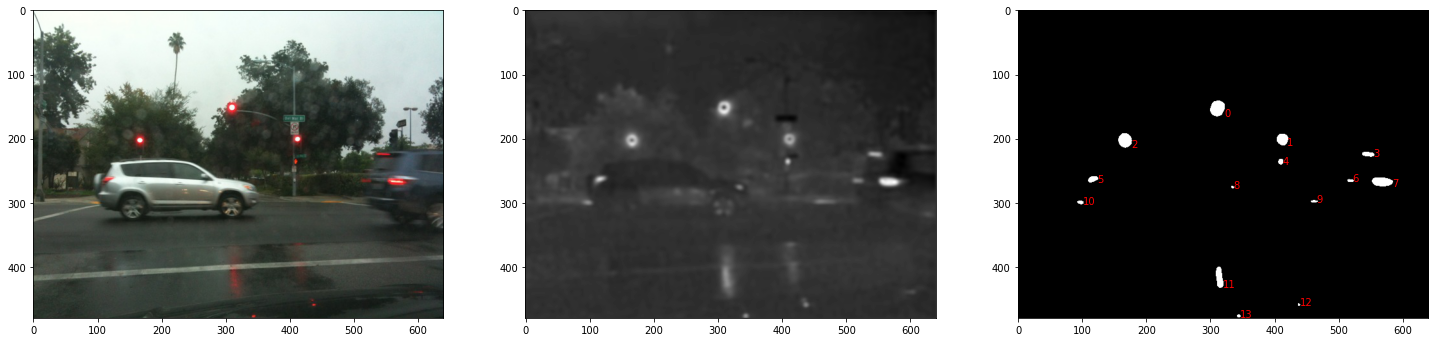


number of patches is 14
areas are [447, 261, 377, 117, 59, 116, 38, 371, 16, 34, 46, 293, 12, 23]
aspect ratios are [0.7991572030643381, 0.7622363174899203, 0.7347723566351296, 1.1433310228097269, 0.7134997025051918, 0.840365540032637, 0.9235174987306033, 1.0812669381755315, 0.6018046285662293, 1.132808712595255, 0.8372933962660581, 1.369112744242738, 0.5371479329351467, 0.5847214213593547]
valid indices are [0, 1, 2, 4, 5, 8, 10, 12, 13]
final boxes are [[141, 299, 165, 321], [193, 403, 210, 420], [192, 156, 214, 177], [232, 405, 240, 412], [259, 109, 268, 124], [274, 332, 277, 336], [297, 92, 302, 101], [457, 436, 460, 439], [474, 341, 478, 346]]
Scores are [0.5251098763634909, 0.34123108048864936, 0.4644312812255715, 0.4171470853255346, 0.4589929970532109, 0.21322742406154768, 0.25277762231154827, 0.2130490362572605, 0.2573972104232375]
Final output is [[141, 299, 165, 321, 0.5251098763634909], [193, 403, 210, 420, 0.34123108048864936], [192, 156, 214, 177, 0.4644312812255715], [23

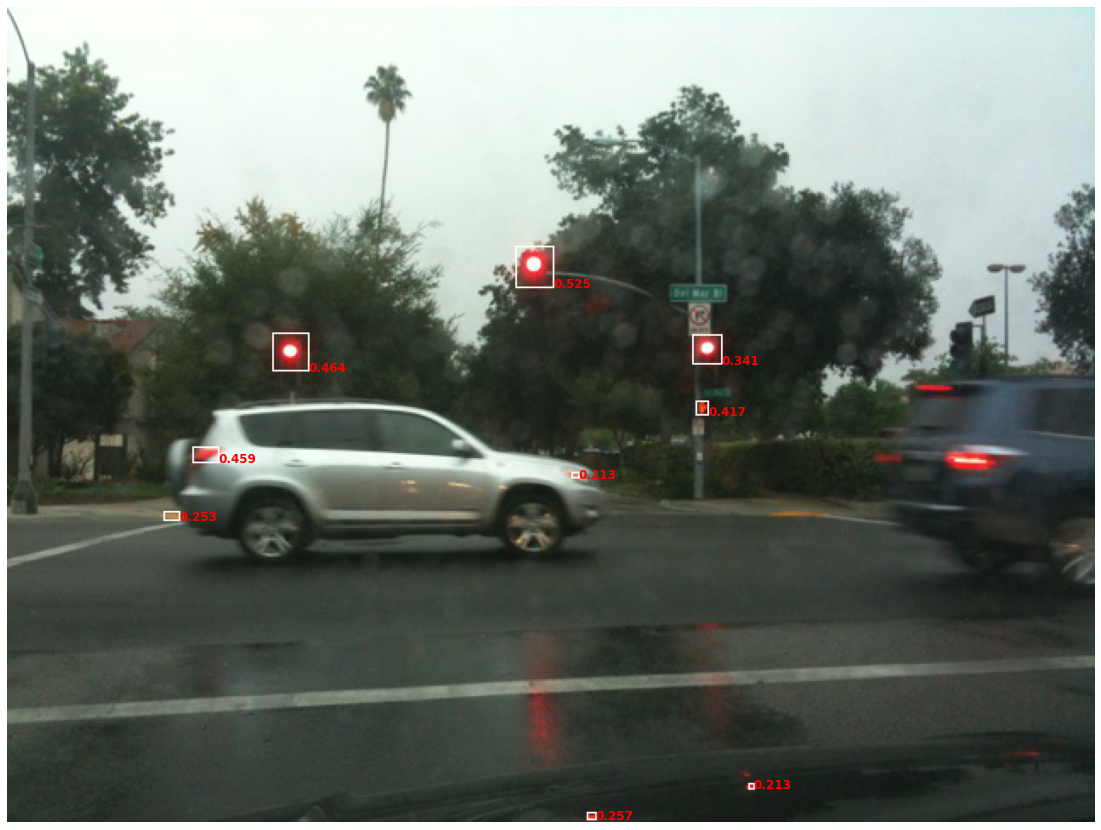

In [36]:
plt.figure(figsize=(25, 20))
plt.subplot(131)
plt.imshow(I)
plt.subplot(132)
plt.imshow(I_filt, cmap='gray')
plt.subplot(133)
plt.imshow(I_thr, cmap='gray')
for idx, box in enumerate(boxes):
    plt.text(box[3], box[2], idx, color='r')
plt.show()
print()
print(f'number of patches is {n_labels}')
print(f'areas are {areas}')
print(f'aspect ratios are {ratios}')
print(f'valid indices are {idc}')
print(f'final boxes are {boxes_final}')
print(f'Scores are {scores_final}')
print(f'Final output is {boxes_combined}')

I2 = I.copy()
color_edge = np.array([255, 255, 255], dtype=np.uint8).reshape((1, 1, 3))
for box in boxes_final:
    I2[box[0]:box[2]+1, box[1], :] = color_edge
    I2[box[0]:box[2]+1, box[3], :] = color_edge
    I2[box[0], box[1]:box[3]+1, :] = color_edge
    I2[box[2], box[1]:box[3]+1, :] = color_edge
plt.figure(figsize=(20, 15))
plt.imshow(I2)
for box in boxes_combined:
    plt.text(box[3], box[2], f'{box[-1]:.3f}', color='r', fontweight='bold', fontsize=12)
plt.gca().axis('off')
plt.show()